In [1]:
%matplotlib notebook
from utils.Dataset import get_new_xray_dataloader
from utils.Transforms import ContrastAdjustment, Normalize
from utils.UNetDilatedResidual import UNetDR as UNetDR
from utils.UNet import UNet
import torch
from torch import optim
import matplotlib.pyplot as plt
from utils.loss import DiceLoss, DiceBCELoss
import numpy as np

In [2]:
lr = 1e-3
weight_decay = 0.0005
momentum = 0.99

In [3]:
trainingset = {
    "images":[".\\images_cropped\\train\\"+str(id)+".jpg" for id in range(1890)],
    "landmarks":[".\\landmarks_cropped\\train\\"+str(id)+".txt" for id in range(1890)],
    "labels":[".\\labels\\train\\"+str(id)+".npy" for id in range(1890)]
              }
testingset = {
    "images":[".\\images_cropped\\test\\"+str(id)+".jpg" for id in range(70)]+[".\\images_cropped\\test\\"+str(id)+".jpg" for id in range(105, 665)],
    "landmarks":[".\\landmarks_cropped\\test\\"+str(id)+".txt" for id in range(70)]+[".\\landmarks_cropped\\test\\"+str(id)+".txt" for id in range(105, 665)],
    "labels":[".\\labels\\test\\"+str(id)+".npy" for id in range(70)]+[".\\labels\\test\\"+str(id)+".npy" for id in range(105, 665)]
              }
unseenset = {
    "images":[".\\images_cropped\\test\\"+str(id)+".jpg" for id in range(70, 105)],
    "landmarks":[".\\landmarks_cropped\\test\\"+str(id)+".txt" for id in range(70, 105)],
    "labels":[".\\labels\\test\\"+str(id)+".npy" for id in range(70, 105)]
            }
cross_validation_set = {"trainingset":trainingset, "testingset":testingset, "unseenset":unseenset}

In [3]:
import pickle
dataset = pickle.load(open(".\\datasources\\newdataset.p", "rb"))
dataloader = get_new_xray_dataloader(dataset, transforms=[ContrastAdjustment(), Normalize()])

In [4]:
import pickle

cross_validation_set = pickle.load(open(".\\datasources\\cross_validation_set_big.pt", "rb"))

images = [".\\images_cropped\\train\\"+str(id)+".jpg" for id in range(105)]
landmarks = [".\\landmarks_cropped\\train\\"+str(id)+".txt" for id in range(105)]
labels = [".\\labels\\train\\"+str(id)+".npy" for id in range(105)]

images_validate = [".\\images_cropped\\test\\"+str(id)+".jpg" for id in range(70)]
landmarks_validate = [".\\landmarks_cropped\\test\\"+str(id)+".txt" for id in range(70)]
labels_validate = [".\\labels\\test\\"+str(id)+".npy" for id in range(70)]
for i in range(105):
    start = 105 + 17*i
    end = start + 5
    images += [".\\images_cropped\\train\\"+str(id)+".jpg" for id in range(start, end)]
    landmarks += [".\\landmarks_cropped\\train\\"+str(id)+".txt" for id in range(start, end)]
    labels += [".\\labels\\train\\"+str(id)+".npy" for id in range(start, end)]
for i in range(70):
    start = 105 + 8*i
    end = start + 3
    images_validate += [".\\images_cropped\\test\\"+str(id)+".jpg" for id in range(start, end)]
    landmarks_validate += [".\\landmarks_cropped\\test\\"+str(id)+".txt" for id in range(start, end)]
    labels_validate += [".\\labels\\test\\"+str(id)+".npy" for id in range(start, end)]
cross_validation_set["trainingset"] = {"images":images, "landmarks":landmarks, "labels":labels}
cross_validation_set["testingset"] =  {"images":images_validate, "landmarks":landmarks_validate, "labels":labels_validate}
pickle.dump(cross_validation_set, open("cross_validation_set_consolidated.pt", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '.\\datasources\\cross_validation_set_big.pt'

1.0 -1.0 1.0 0.0 float32


<IPython.core.display.Javascript object>


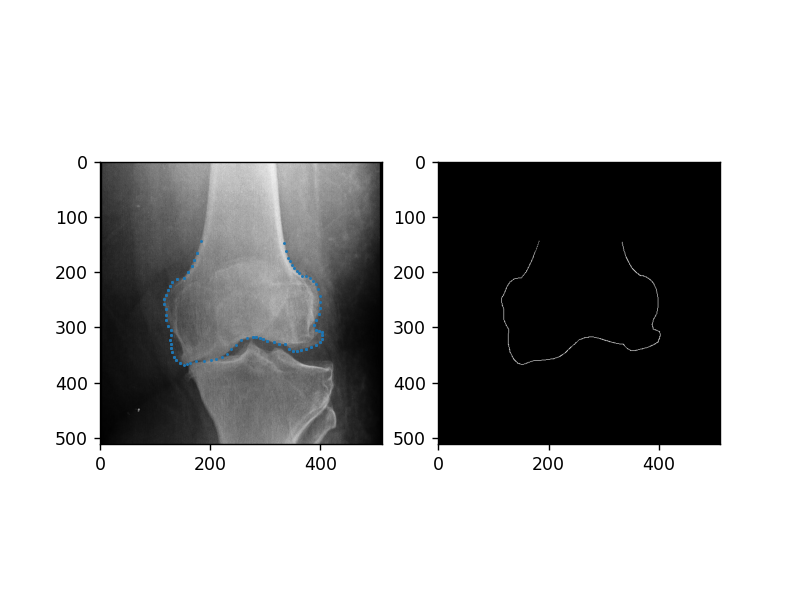

In [5]:
sample = next(iter(dataloader["testloader"]))
image, label, landmarks = sample["image"].type(torch.float32).squeeze_(dim=0).numpy(), sample["label"].type(torch.float32).squeeze_(0).numpy(), sample["landmarks"].squeeze_(0).numpy()
print(image.max(), image.min(), label.max(), label.min(), image.dtype)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(image, "gray")
ax1.scatter(landmarks[:,0], landmarks[:,1], s=0.5)
ax2.imshow(label, "gray")
plt.show()
for i in range(512):
    for j in range(512):
        if 0.0 < label[i,j] < 1.0:
            print(True)

In [4]:
from torch import nn
def get_spatial_conv(input_channels=1, num_filters=128, kernel_size=11, padding=5, count=3):
    layers = [nn.Conv2d(input_channels, num_filters, kernel_size, padding=padding), nn.ReLU(inplace=False)]
    for c in range(count-2):
        layers.append(nn.Conv2d(num_filters, num_filters, kernel_size, padding=padding))
        layers.append(nn.ReLU(inplace=False))
    layers.append(nn.Conv2d(num_filters, input_channels, kernel_size, padding=padding))
    return nn.Sequential(*layers)
class StackUNet(nn.Module):
    def __init__(self, input_channels=1, n_filters = 128, dropout = 0.1, batchnorm = False, first_unet=False):
        super(StackUNet, self).__init__()
        self.first_unet = first_unet
        self.spatial_conv = get_spatial_conv()
        self.AvgPool16 = nn.AvgPool2d(16)
        self.Upsample = nn.Upsample(scale_factor=16, mode="bicubic", align_corners=True)
        self.first_unet.eval()
    def forward(self, x):
        with torch.no_grad():
            x_1 = torch.sigmoid(self.first_unet(x))
        x_1  = self.AvgPool16(x_1)
        x = self.spatial_conv(x_1)
        x = self.Upsample(x)
        return x

In [4]:
use_cuda = torch.cuda.is_available()
'''
first_unet = UNet()
if use_cuda:
    first_unet = first_unet.cuda()
prelearned_weights = torch.load(".\\weights\\model_unet_dict.pt")["model_state_dict"]
first_unet.load_state_dict(prelearned_weights)
for p in first_unet.parameters():
    p.requires_grad = False
'''
unet = UNet()
if use_cuda:
    unet = unet.cuda()

model_dict = torch.load(".\\weights\\model_unet_deconv_regularized_dict.pth")
unet.load_state_dict(model_dict["model_state_dict"])


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=2e-4, weight_decay=2e-6)#optim.SGD(unet.parameters(), lr=2e-4, momentum=momentum, nesterov=True, weight_decay=weight_decay) #optim.Adam(unet.parameters(), lr=1e-3, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, min_lr=1e-4, verbose=True)

In [6]:
loss = torch.load(".\\weights\\model_unet_dict.pt")["loss"]
loss  0.007801

tensor(0.0079, device='cuda:0')

In [14]:
import time
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda=False, save_path=".\\weights\\model_unet_deconv_regularized_dict.pth", load_weights=False, scheduler=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = 0.006909 #np.Inf
    
    if load_weights:
        model_dict = torch.load(save_path)
        model.load_state_dict(model_dict["model_state_dict"])
        #optimizer.load_state_dict(model_dict["optimizer_state_dict"])
        valid_loss_min = model_dict["loss"]
        print("model, optimizer and loss loaded")
        
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        start_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, sample in enumerate(loaders['trainloader']):
            optimizer.zero_grad()
            # move to GPU
            image, label = sample["image"].unsqueeze_(dim=1).type(torch.float32), sample["label"].unsqueeze_(dim=0).type(torch.float32)
            
            if use_cuda:
                image, label = image.cuda(), label.cuda()
                label *= 0.9
            #with torch.no_grad():
                #image = torch.sigmoid(unet_first(image))
            prediction = model(image)
            loss = criterion(prediction, label)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 500 == 0:
                print('Epoch: {} \tTraining Loss: {:.6f} after {} batches'.format(epoch, train_loss, batch_idx))
                #if scheduler is not None:
                    #scheduler.step(train_loss) 
        
            #if scheduler is not None:
                #scheduler.step(train_loss)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, sample in enumerate(loaders['validloader']):
            # move to GPU
            image, label = sample["image"].unsqueeze_(dim=1).type(torch.float32), sample["label"].unsqueeze_(dim=0).type(torch.float32)
            if use_cuda:
                image, label = image.cuda(), label.cuda()
                label *= 0.9
            ## update the average validation loss
            with torch.no_grad():
                #image = torch.sigmoid(unet_first(image))
                prediction = model(image)
                loss = criterion(prediction, label)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if scheduler is not None:
            scheduler.step(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min: #
            print("Saving the model")
            valid_loss_min = valid_loss
            model_dict = {'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(), 'loss':valid_loss_min}
            torch.save(model_dict, save_path)
        end_time = time.time()
        print("Training Epoch  "+str(epoch)+" th finished in "+str(end_time-start_time))
    return model, optimizer

In [15]:
torch.autograd.set_detect_anomaly(True)
epochs = 1
unet, optimizer = train(epochs, dataloader, unet, optimizer, criterion, use_cuda, load_weights=False, scheduler=None)

Epoch: 1 	Training Loss: 0.008506 after 0 batches
Epoch: 1 	Training Loss: 0.006192 after 500 batches
Epoch: 1 	Training Loss: 0.006109 after 1000 batches
Epoch: 1 	Training Loss: 0.006093 after 1500 batches
Epoch: 1 	Training Loss: 0.006089 after 2000 batches
Epoch: 1 	Training Loss: 0.006101 after 2500 batches
Epoch: 1 	Training Loss: 0.006108 after 3000 batches
Epoch: 1 	Training Loss: 0.006097 after 3500 batches
Epoch: 1 	Training Loss: 0.006086 after 4000 batches
Epoch: 1 	Training Loss: 0.006096 after 4500 batches
Epoch: 1 	Training Loss: 0.006080 after 5000 batches
Epoch: 1 	Training Loss: 0.006070 	Validation Loss: 0.006900
Saving the model
Training Epoch  1 th finished in 2490.615653514862


In [58]:
#prelearned_weights = torch.load(".\\weights\\model_unet_deconv_dict.pth")["model_state_dict"]
#unet.load_state_dict(prelearned_weights)
unet.eval()
valid_loss = 0
for batch_idx, sample in enumerate(dataloader['testloader']):
            # move to GPU
            image, label = sample["image"].unsqueeze_(dim=1).type(torch.float32), sample["label"].unsqueeze_(dim=0).type(torch.float32)
            if use_cuda:
                image, label = image.cuda(), label.cuda()
                label *= 0.9
            ## update the average validation loss
            with torch.no_grad():
                prediction = unet(image)
                loss = criterion(prediction, label)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
print("{:.6f}".format(valid_loss.data))

0.006310


0.5127824 1.6857241e-20 float32


<IPython.core.display.Javascript object>


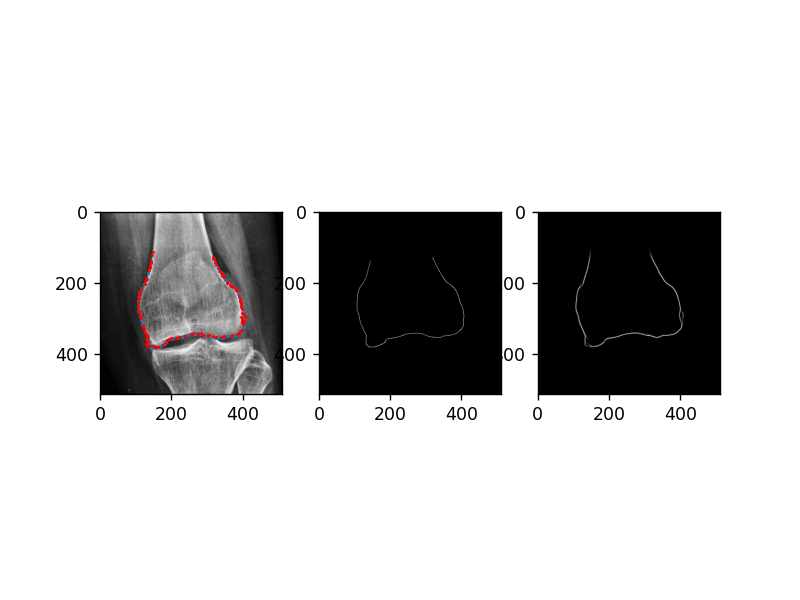

In [13]:
#unet.load_state_dict(torch.load(".\\weights\\model_unet_deconv_dict.pth")["model_state_dict"])
import cv2
import matplotlib
unet.eval()
sample = next(iter(dataloader["testloader"]))
image, landmarks, label = sample["image"].unsqueeze_(dim=1).type(torch.float32), sample["landmarks"].squeeze_(dim=0).numpy(), sample["label"].squeeze_(dim=0).numpy()

original_image = image.clone()
if use_cuda:
    image = image.cuda()

with torch.no_grad():
    #image = torch.sigmoid(unet_first(image))
    response_image = torch.sigmoid(unet(image)).squeeze_(dim=0).squeeze_(dim=0).cpu() #apply sigmoid

original_image = original_image.squeeze_(dim=0).squeeze_(dim=0).cpu()
image = image.squeeze_(dim=0).squeeze_(dim=0).cpu()

response_image = response_image.numpy()



y, x = np.where(response_image > 0.1 )

pred_landmarks = np.zeros((y.shape[0], 2))
pred_landmarks[:,0] = x
pred_landmarks[:,1] = y
path = matplotlib.path.Path(pred_landmarks).interpolated(0.05).vertices

print(response_image.max() , response_image.min(), response_image.dtype)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(original_image.numpy(), "gray")
ax1.scatter(landmarks[:,0], landmarks[:,1], s=0.5)
ax1.scatter(path[:,0], path[:,1], s=0.5, color="red")
ax2.imshow(label, "gray")
ax3.imshow(response_image, "gray")
plt.show()